### Bayesian RegressionをNumpyroで実装する

### PackageとDatasetの準備

In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

In [3]:
# WaffleDivorce Setという名前の, 離婚率、人口、結構年齢の中央値、南部かどうかのフラグに加えて、ワッフル屋の数などの変数が含まれているデータセットを用いて回帰を行う. 
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


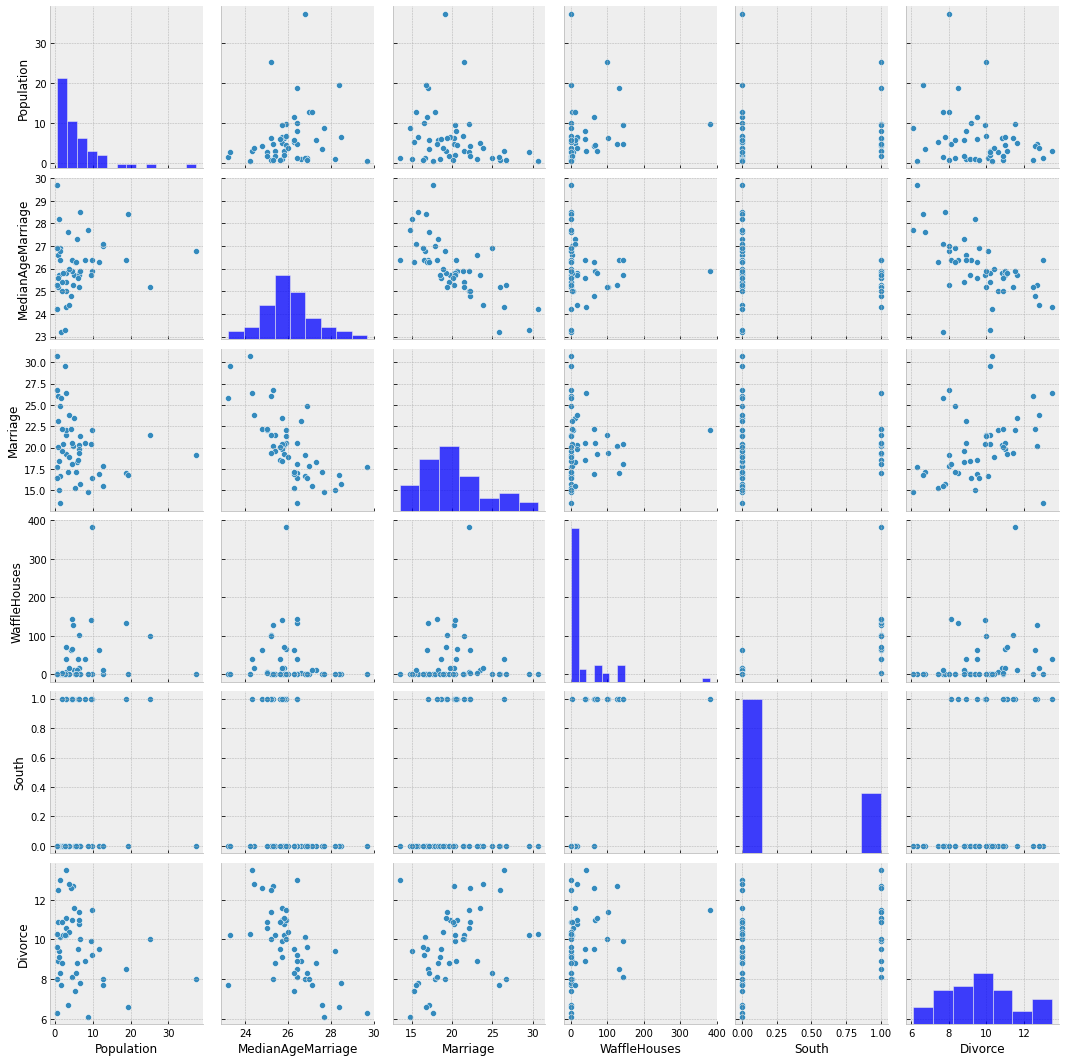

In [4]:
# 変数ごとの相関プロットを確認すると, 州の離婚率と結婚率との間や、離婚率と結婚年齢の中央値の間に相関が確認でき擬装感
vars = ['Population', 'MedianAgeMarriage', 'Marriage', 'WaffleHouses', 'South', 'Divorce']
艤装議儀sns.pairplot(dset, x_vars=vars, y_vars=vars, palette='husl');

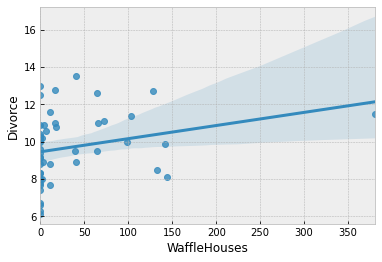

In [5]:
# ワッフル屋を説明変数として, 離婚率を予測することで、正の相関が確認できるが、これは偽の相関
sns.regplot('WaffleHouses', 'Divorce', dset);

以下では婚姻率と結婚年齢の中央値を基に, numpyroで離婚率を予測するモデルを構築する

## 婚姻率を基にした, 離婚率の予測モデル (ベイジアン単回帰)
### 1. Dataの前処理とモデルの構築

In [6]:
standardize = lambda x: (x - x.mean()) / x.std()

# 変数の正規化をする.
dset['AgeScaled'] = dset.MedianAgeMarriage.pipe(standardize)
dset['MarriageScaled'] = dset.Marriage.pipe(standardize)
dset['DivorceScaled'] = dset.Divorce.pipe(standardize)

In [7]:
# Numpyroでのモデルの構築. 
# samplingする際に, キーワード引数を与えることができる.
# 単回帰を行う際にも扱えるように, if文で条件づけてサンプルする/しないを決める
def model(marriage=None, age=None, divorce=None):

    a = numpyro.sample('a', dist.Normal(0., 0.2))
    
    M, A = 0., 0.
    if marriage is not None:
        bM = numpyro.sample('bM', dist.Normal(0., 0.5))
        M = bM * marriage
    
    if age is not None:
        bA = numpyro.sample('bA', dist.Normal(0., 0.5))
        A = bA * age
    
    # 標準偏差は指数型分布からサンプリングする
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    
    # 平均は, ベースのaの値と, marriageの効果, ageの効果の和で算出(再生性より)する
    mu = a + M + A

    # パラメータに従うサンプリングを行う. 
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

### 2. 事後分布のMCMCサンプリング

In [9]:
# 乱数のキーを作成して, キーをランダム分割しておく.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# warmup期間とサンプル数を設定する. 
num_warmup, num_samples = 1000, 2000

# modelに基づいた, MCMCサンプリングを実施する. 
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, marriage=dset['MarriageScaled'].values, divorce=dset['DivorceScaled'].values)
mcmc.print_summary()

# MCMCのサンプルをsamples_1に格納する
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 370.54it/s, 3 steps of size 7.48e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.11     -0.00     -0.17      0.18   1804.63      1.00
        bM      0.35      0.13      0.35      0.13      0.56   1556.49      1.00
     sigma      0.94      0.10      0.94      0.78      1.08   1916.15      1.00

Number of divergences: 0


In [20]:
samples_1

{'a': DeviceArray([ 0.00265072,  0.08105423,  0.01616203, ...,  0.1491687 ,
              -0.21335354, -0.0132151 ], dtype=float32),
 'bM': DeviceArray([0.38571444, 0.2795746 , 0.11082313, ..., 0.44009432,
              0.1087914 , 0.20957291], dtype=float32),
 'sigma': DeviceArray([1.0226512 , 0.95852596, 0.85703236, ..., 0.7834619 ,
              1.1063427 , 0.8970469 ], dtype=float32)}

### 3. 予測分布の算出

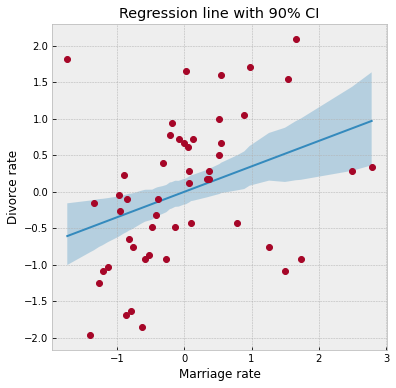

In [10]:
# 事後分布のサンプルを基に, 平均値の90%ベイズ信頼区間を算出してプロットする
def plot_regression(x, y_mean, y_hpdi):

    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset['DivorceScaled'].values[idx]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

posterior_mu = jnp.expand_dims(samples_1['a'], -1) + \
               jnp.expand_dims(samples_1['bM'], -1) * dset['MarriageScaled'].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)


ax = plot_regression(dset['MarriageScaled'].values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

In [15]:
from numpyro.infer import Predictive

# numpyro.infer内の関数を使うことで, 予測分布を算出することができる. 
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset['MarriageScaled'].values)['obs']
df = dset.filter(['Location'])
df['Mean Predictions'] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,-0.017218
1,Alaska,0.582299
2,Arizona,0.018285
3,Arkansas,0.539564
4,California,-0.085100


In [23]:
# 予測分布を算出するための関数
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace['obs']['value']

# vectorize predictions via vmap
predict_fn = vmap(lambda rng_key, samples: predict(rng_key, samples, model, marriage=dset['MarriageScaled'].values))

In [27]:
predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(['Location'])
df['Mean Predictions'] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,-0.017218
1,Alaska,0.582299
2,Arizona,0.018285
3,Arkansas,0.539564
4,California,-0.085100


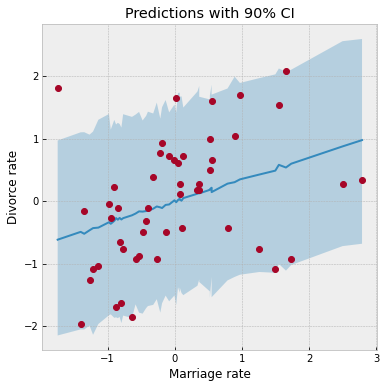

In [31]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset['MarriageScaled'].values, mean_pred, hpdi_pred)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Predictions with 90% CI');

## 結婚した年齢の中央値を基にした, 離婚率の予測モデル (ベイジアン単回帰)
### MCMCサンプリング -> 事後分布のプロット -> 予測分布のプロット

In [32]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 364.11it/s, 7 steps of size 7.27e-01. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.18      0.15   1743.07      1.00
        bA     -0.56      0.12     -0.56     -0.76     -0.39   1738.54      1.00
     sigma      0.82      0.08      0.81      0.68      0.95   1696.44      1.00

Number of divergences: 0


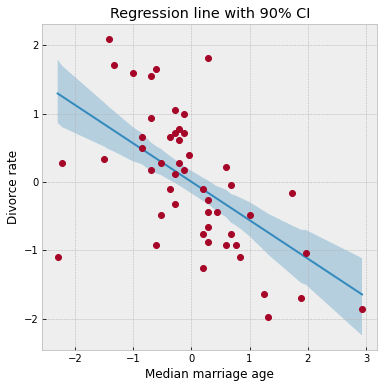

In [33]:
posterior_mu = jnp.expand_dims(samples_2['a'], -1) + \
               jnp.expand_dims(samples_2['bA'], -1) * dset['AgeScaled'].values
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset['AgeScaled'].values, mean_mu, hpdi_mu)
ax.set(xlabel='Median marriage age', ylabel='Divorce rate', title='Regression line with 90% CI');

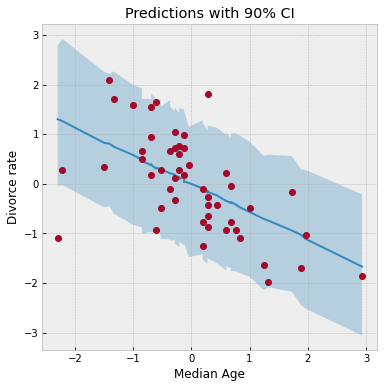

In [34]:
rng_key, rng_key_ = random.split(rng_key)
predictions_2 = Predictive(model, samples_2)(rng_key_,
                                             age=dset['AgeScaled'].values)['obs']

mean_pred = jnp.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset['AgeScaled'].values, mean_pred, hpdi_pred)
ax.set(xlabel='Median Age', ylabel='Divorce rate', title='Predictions with 90% CI');

In [36]:
# 対数尤度関数
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])

# 対数事後予測密度
def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

In [37]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(log_pred_density(rng_key_,
                                                    samples_2,
                                                    model,
                                                    age=dset.AgeScaled.values,
                                                    divorce=dset.DivorceScaled.values)))

Log posterior predictive density: -59.221012115478516


### 婚姻率と結婚年齢の中央値を基に, 離婚率を予測する

In [38]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, marriage=dset.MarriageScaled.values,
         age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:09<00:00, 307.69it/s, 1 steps of size 5.43e-01. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.01      0.10     -0.01     -0.17      0.16   1911.51      1.00
        bA     -0.61      0.16     -0.61     -0.87     -0.36   1435.36      1.00
        bM     -0.06      0.16     -0.05     -0.33      0.20   1367.43      1.00
     sigma      0.83      0.09      0.82      0.70      0.98   1875.44      1.00

Number of divergences: 0


In [39]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(
    log_pred_density(rng_key_,
                     samples_3,
                     model,
                     marriage=dset.MarriageScaled.values,
                     age=dset.AgeScaled.values,
                     divorce=dset.DivorceScaled.values)
))

Log posterior predictive density: -59.053497314453125


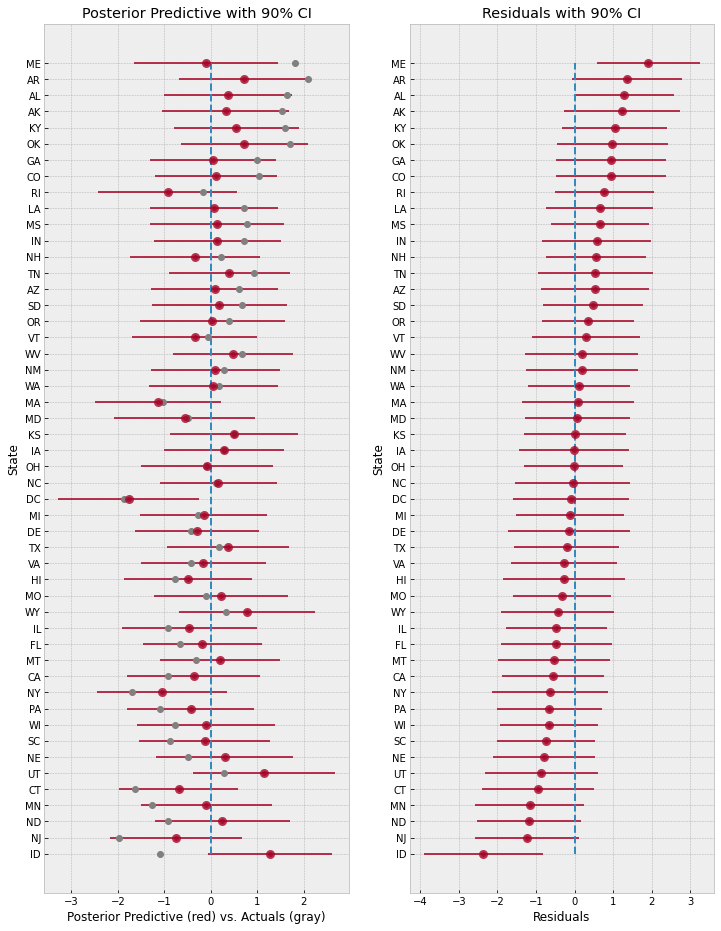

In [40]:
# Predictions for Model 3.
rng_key, rng_key_ = random.split(rng_key)
predictions_3 = Predictive(model, samples_3)(rng_key_,
                                             marriage=dset.MarriageScaled.values,
                                             age=dset.AgeScaled.values)['obs']
y = jnp.arange(50)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = jnp.mean(predictions_3, axis=0)
pred_hpdi = hpdi(predictions_3, 0.9)
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
idx = jnp.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(jnp.zeros(50), y, '--')
ax[0].errorbar(pred_mean[idx], y, xerr=pred_hpdi[1, idx] - pred_mean[idx],
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker='o',
           ls='none', color='gray')
ax[0].set(xlabel='Posterior Predictive (red) vs. Actuals (gray)', ylabel='State',
          title='Posterior Predictive with 90% CI')
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10);

# Plot residuals
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(jnp.zeros(50), y, '--')
ax[1].errorbar(residuals_mean[idx], y, xerr=err[idx],
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[1].set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10);

### 測定誤差を変数に加えた回帰モデル

In [41]:
def model_se(marriage, age, divorce_sd, divorce=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    bM = numpyro.sample('bM', dist.Normal(0., 0.5))
    M = bM * marriage
    bA = numpyro.sample('bA', dist.Normal(0., 0.5))
    A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    divorce_rate = numpyro.sample('divorce_rate', dist.Normal(mu, sigma))
    numpyro.sample('obs', dist.Normal(divorce_rate, divorce_sd), obs=divorce)

In [42]:
# 離婚率の標準語差をデータフレームに入れる
dset['DivorceScaledSD'] = dset['Divorce SE'] / jnp.std(dset.Divorce.values)

In [43]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_se, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, age=dset.AgeScaled.values,
         divorce_sd=dset.DivorceScaledSD.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_4 = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:10<00:00, 366.21it/s, 15 steps of size 2.38e-01. acc. prob=0.94]

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
               a     -0.05      0.10     -0.05     -0.21      0.11   1771.73      1.00
              bA     -0.62      0.16     -0.62     -0.89     -0.37   1716.76      1.00
              bM      0.05      0.17      0.05     -0.22      0.32   1501.22      1.00
 divorce_rate[0]      1.15      0.37      1.15      0.57      1.77   2890.85      1.00
 divorce_rate[1]      0.68      0.55      0.67     -0.27      1.53   3047.57      1.00
 divorce_rate[2]      0.41      0.33      0.41     -0.14      0.94   3530.29      1.00
 divorce_rate[3]      1.41      0.46      1.40      0.66      2.18   2863.22      1.00
 divorce_rate[4]     -0.90      0.13     -0.90     -1.10     -0.66   5288.33      1.00
 divorce_rate[5]      0.65      0.41      0.64     -0.02      1.31   4266.70      1.00
 divorce_rate[6]     -1.3

In [44]:
rng_key, rng_key_ = random.split(rng_key)
predictions_4 = Predictive(model_se, samples_4)(rng_key_,
                                                marriage=dset.MarriageScaled.values,
                                                age=dset.AgeScaled.values,
                                                divorce_sd=dset.DivorceScaledSD.values)['obs']

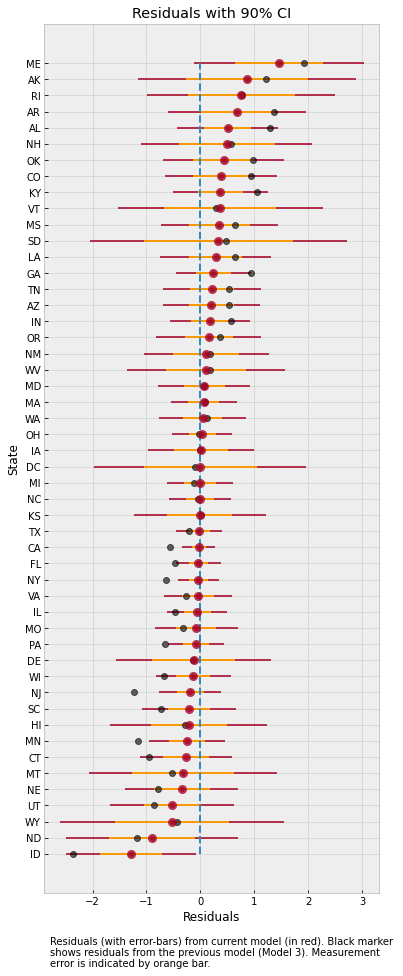

In [45]:
sd = dset.DivorceScaledSD.values
residuals_4 = dset.DivorceScaled.values - predictions_4
residuals_mean = jnp.mean(residuals_4, axis=0)
residuals_hpdi = hpdi(residuals_4, 0.9)
err = residuals_hpdi[1] - residuals_mean
idx = jnp.argsort(residuals_mean)
y = jnp.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 16))


# Plot Residuals
ax.plot(jnp.zeros(50), y, '--')
ax.errorbar(residuals_mean[idx], y, xerr=err[idx],
            marker='o', ms=5, mew=4, ls='none', alpha=0.8)

# Plot SD
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx],
            ls='none', color='orange', alpha=0.9)

# Plot earlier mean residual
ax.plot(jnp.mean(dset.DivorceScaled.values - predictions_3, 0)[idx], y,
        ls='none', marker='o', ms=6, color='black', alpha=0.6)

ax.set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax.set_yticks(y)
ax.set_yticklabels(dset.Loc.values[idx], fontsize=10);
ax.text(-2.8, -7, 'Residuals (with error-bars) from current model (in red). '
                  'Black marker \nshows residuals from the previous model (Model 3). '
                  'Measurement \nerror is indicated by orange bar.');

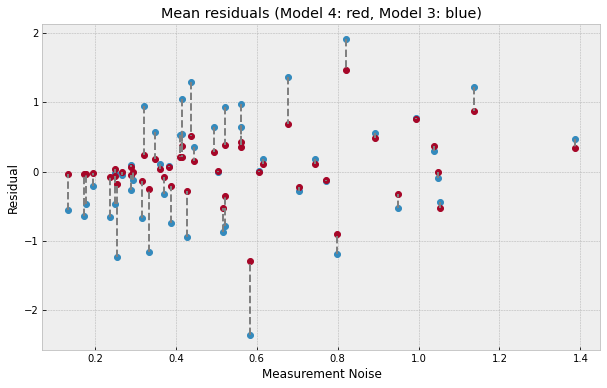

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = dset.DivorceScaledSD.values
y1 = jnp.mean(residuals_3, 0)
y2 = jnp.mean(residuals_4, 0)
ax.plot(x, y1, ls='none', marker='o')
ax.plot(x, y2, ls='none', marker='o')
for i, (j, k)  in enumerate(zip(y1, y2)):
    ax.plot([x[i], x[i]], [j, k], '--', color='gray');

ax.set(xlabel='Measurement Noise', ylabel='Residual', title='Mean residuals (Model 4: red, Model 3: blue)');